# pytorch模型定义+进阶训练技巧
- 模型定义方式
- 利用模型块快速搭建复杂网络
- 模型修改
- 模型的保存与读取
- 自定义损失函数
- 动态调整学习率
- 模型微调
- 半精度训练

In [2]:
import os
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

## Part 1:模型定义方式
- Sequential
- ModuleLIst
- ModuleDict

In [3]:
##Sequential :DIrect list
import torch.nn as nn 
net1 = nn.Sequential(
    nn.Linear(784,256),
    nn.ReLU(),
    nn.Linear(256,10)
)
print(net1)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [4]:
##Sequential: Order Dict(有顺序的字典)
import collections
import torch.nn as nn
net2 = nn.Sequential(collections.OrderedDict([
    ('fc1',nn.Linear(784,256)),
    ('relu1',nn.ReLU()),
    ('fc2',nn.Linear(256,10))   
]))
print(net2)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [5]:
#试一下
a = torch.rand(4,784)
out1 = net1(a)
out2 = net2(a)
print(out1.shape==out2.shape,out1.shape)

True torch.Size([4, 10])


In [6]:
## Modele List 很多层是一样的情况下
net3 = nn.ModuleList([nn.Linear(784,256),nn.ReLU()])
net3.append(nn.Linear(256,10))
print(net3[-1])
print(net3)

Linear(in_features=256, out_features=10, bias=True)
ModuleList(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)


In [7]:
# 注意ModuleList 并没有定义一个网络，它只是将不同的模块储存在一起，此处应报错
# out3 = net3(a) #没有前馈，不知道网络的顺序

In [8]:
#写到初始化函数里面，利用初始化函数将模型层定义好
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.Modulelist = nn.ModuleList([nn.Linear(784,256),nn.ReLU()])
        self.Modulelist.append(nn.Linear(256,10))
    
    def forward(self,x):
        for layer in self.Modulelist:
            x = layer(x)
        return x
net3_ = Net3()
out3_ = net3_(a)
print(out3_.shape)

torch.Size([4, 10])


In [9]:
## ModuleDict
net4 = nn.ModuleDict({
    'linear':nn.Linear(784,256),
    'act':nn.ReLU()
})
net4['output'] = nn.Linear(256,10)
print(net4['linear'])
print(net4.output)

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=10, bias=True)


In [10]:
# Module并没有定义一个网络，他只是将不同的模块存储在一起，此处应报错
# out4 = net4(a)

## Point2 利用模型块快速搭建复杂网络
- 快速构建U-Net网络

![](https://camo.githubusercontent.com/41ded1456b9dbe13b8d73d8da539dac95cb8aa721ebe5fb798af732ca9f04c92/68747470733a2f2f692e696d6775722e636f6d2f6a6544567071462e706e67)

In [1]:
import os
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
import zipfile
f = zipfile.ZipFile("./archive.zip",'r') # 原压缩文件在服务器的位置
for file in f.namelist():
  f.extract(file,"./") #解压到的位置，./表示当前目录(与此.ipynb文件同一个目录)
f.close()

In [3]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels,mid_channels = None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels,mid_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(mid_channels), #
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.double_conv(x)

In [4]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [5]:
class Up(nn.Module): #上采样
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [6]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
## 组装
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [34]:
unet = UNet(3,1)
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

### Point3:模型修改
- 假设最后分割的类别是多类别的（即mask不止0和1，还有2,3,4等值代表其他目标），需要对模型特定层进行修改
- 添加额外输入
- 添加额外输出

In [53]:
## 修改特定层
import copy
unet1 = copy.deepcopy(unet)
unet1.outc

OutConv(
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [54]:
unet1

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [55]:
unet1.outc = OutConv(64,5)
unet1.outc

OutConv(
  (conv): Conv2d(64, 5, kernel_size=(1, 1), stride=(1, 1))
)

In [57]:
b = torch.rand(1,3,224,224)
out_unet1 = unet1(b) 
out_unet1.shape #原来的是[1,1,224,224]

torch.Size([1, 5, 224, 224])

In [58]:
## 添加额外的输入
class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x, add_variable):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = x + add_variable   #修改点，模型定义要有所变化
        logits = self.outc(x)
        return logits
unet2 = UNet2(3,1)

c = torch.rand(1,1,224,224)
out_unet2 = unet2(b, c)
print(out_unet2.shape)

torch.Size([1, 1, 224, 224])


In [59]:
## 添加额外输出
class UNet3(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet3, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, x5  # 修改点
unet3 = UNet3(3,1)

c = torch.rand(1,1,224,224)
out_unet3, mid_out = unet3(b)
print(out_unet3.shape, mid_out.shape)

torch.Size([1, 1, 224, 224]) torch.Size([1, 512, 14, 14])


### Point4：模型的保存与读取
- 考虑单卡或多卡情况下的模型存取情况

In [60]:
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [61]:
unet.state_dict() #weights

OrderedDict([('inc.double_conv.0.weight',
              tensor([[[[-0.0199,  0.0080, -0.1664],
                        [-0.0974, -0.0201, -0.1885],
                        [ 0.1254,  0.0654, -0.1416]],
              
                       [[-0.0869, -0.1342,  0.0480],
                        [-0.0304,  0.0066, -0.0158],
                        [ 0.1616,  0.0257,  0.1317]],
              
                       [[-0.0362, -0.1633, -0.1773],
                        [ 0.0133, -0.0989, -0.0333],
                        [ 0.0512, -0.0007,  0.1281]]],
              
              
                      [[[ 0.0090, -0.1906,  0.0002],
                        [ 0.1735,  0.0413,  0.0184],
                        [ 0.0709,  0.0444,  0.1659]],
              
                       [[-0.0297, -0.0366,  0.0126],
                        [-0.1099, -0.1627, -0.0414],
                        [ 0.1397, -0.1732,  0.1211]],
              
                       [[-0.1069, -0.1586,  0.1216],
              

In [62]:
## CPU或单卡：保存&读取整个模型
torch.save(unet,"./unet_example.pth")
loaded_unet = torch.load("./unet_example.pth")
loaded_unet.state_dict()

OrderedDict([('inc.double_conv.0.weight',
              tensor([[[[-0.0199,  0.0080, -0.1664],
                        [-0.0974, -0.0201, -0.1885],
                        [ 0.1254,  0.0654, -0.1416]],
              
                       [[-0.0869, -0.1342,  0.0480],
                        [-0.0304,  0.0066, -0.0158],
                        [ 0.1616,  0.0257,  0.1317]],
              
                       [[-0.0362, -0.1633, -0.1773],
                        [ 0.0133, -0.0989, -0.0333],
                        [ 0.0512, -0.0007,  0.1281]]],
              
              
                      [[[ 0.0090, -0.1906,  0.0002],
                        [ 0.1735,  0.0413,  0.0184],
                        [ 0.0709,  0.0444,  0.1659]],
              
                       [[-0.0297, -0.0366,  0.0126],
                        [-0.1099, -0.1627, -0.0414],
                        [ 0.1397, -0.1732,  0.1211]],
              
                       [[-0.1069, -0.1586,  0.1216],
              

In [64]:
## CPU或单卡：保存&读取模型权重
torch.save(unet.state_dict(),"./unet_weights_example.pth")
loaded_unet_weights = torch.load("./unet_weights_example.pth")
unet.load_state_dict(loaded_unet_weights)
unet.state_dict()

OrderedDict([('inc.double_conv.0.weight',
              tensor([[[[-0.0199,  0.0080, -0.1664],
                        [-0.0974, -0.0201, -0.1885],
                        [ 0.1254,  0.0654, -0.1416]],
              
                       [[-0.0869, -0.1342,  0.0480],
                        [-0.0304,  0.0066, -0.0158],
                        [ 0.1616,  0.0257,  0.1317]],
              
                       [[-0.0362, -0.1633, -0.1773],
                        [ 0.0133, -0.0989, -0.0333],
                        [ 0.0512, -0.0007,  0.1281]]],
              
              
                      [[[ 0.0090, -0.1906,  0.0002],
                        [ 0.1735,  0.0413,  0.0184],
                        [ 0.0709,  0.0444,  0.1659]],
              
                       [[-0.0297, -0.0366,  0.0126],
                        [-0.1099, -0.1627, -0.0414],
                        [ 0.1397, -0.1732,  0.1211]],
              
                       [[-0.1069, -0.1586,  0.1216],
              

In [66]:
## 多卡：保存&读取整个模型。注意模型层名称前多了module
## 不建议，因为保存模型的GPU_id等信息和独缺后训练环境可能不同，尤其是要把保存的模型交给另一个用户的情况
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
unet_mul = copy.deepcopy(unet)
unet_mul = nn.DataParallel(unet_mul).cuda() #分布到不同的卡上
unet_mul

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [ ]:
torch.save(unet_mul,"./unet_mul_example.pth")
loaded_unet_mul = torch.save("./unet_mul_example.pth")
loaded_unet_mul

In [ ]:
## 多卡：保存&读取模型权重
torch.save(unet_mul.state_dict(),"./unet_weight_mul_example.pth")
loaded_unet_weights_mul = torch.load("./unet_weight_mul_example.pth")
unet_mul.load_state_dict(loaded_unet_weights_mul)
unet_mul = nn.DataParallel(unet_mul).cuda()
unet_mul.state_dict()

In [ ]:
#另外，如果保存的是整个模型，也建议采用提取权重的方式构建新的模型

## 利用搭建好的U-Net模型，使用Carvana数据集，实现一个基本的U-Net训练过程

In [41]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [30]:
class CarvanaDataset(Dataset):
    def __init__(self, base_dir, idx_list, mode="train", transform=None):
        self.base_dir = base_dir
        self.idx_list = idx_list
        self.images = os.listdir(base_dir+"train_images")
        self.masks = os.listdir(base_dir+"train_masks")
        self.mode = mode
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self, index):
        image_file = self.images[self.idx_list[index]]
        mask_file = image_file[:-4]+".png"
        image = PIL.Image.open(os.path.join(base_dir, "train_images", image_file))
        if self.mode=="train":
            mask = PIL.Image.open(os.path.join(base_dir, "train_masks", mask_file))
            if self.transform is not None:
                image = self.transform(image)
                mask = self.transform(mask)
                mask[mask!=0] = 1.0
            return image, mask.float()
        else:
            if self.transform is not None:
                image = self.transform(image)
            return image

base_dir = "./"
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_idxs, val_idxs = train_test_split(range(len(os.listdir(base_dir+"train_masks"))), test_size=0.3)
train_data = CarvanaDataset(base_dir, train_idxs, transform=transform)
val_data = CarvanaDataset(base_dir, val_idxs, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=False)

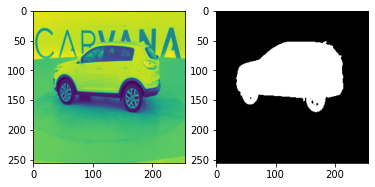

In [31]:
image, mask = next(iter(train_loader))
plt.subplot(121)
plt.imshow(image[0,0])
plt.subplot(122)
plt.imshow(mask[0,0], cmap="gray")

In [35]:
# 使用binary Cross Entropy Loss,之后我们会尝试替换为自定义的Loss
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(),lr = 1e-3,weight_decay=1e-8)

unet = nn.DataParallel(unet).cuda()

In [36]:
def dice_coeff(pred, target):  #评价分割模型好坏的指标
    eps = 0.0001
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + eps) / (m1.sum() + m2.sum() + eps)

def train(epoch):
    unet.train()
    train_loss = 0
    for data, mask in train_loader:
        data, mask = data.cuda(), mask.cuda()
        optimizer.zero_grad()
        output = unet(data)
        loss = criterion(output,mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

def val(epoch):  
    print("current learning rate: ", optimizer.state_dict()["param_groups"][0]["lr"])
    unet.eval()
    val_loss = 0
    dice_score = 0
    with torch.no_grad():
        for data, mask in val_loader:
            data, mask = data.cuda(), mask.cuda()
            output = unet(data)
            loss = criterion(output, mask)
            val_loss += loss.item()*data.size(0)
            dice_score += dice_coeff(torch.sigmoid(output).cpu(), mask.cpu())*data.size(0)
    val_loss = val_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    print('Epoch: {} \tValidation Loss: {:.6f}, Dice score: {:.6f}'.format(epoch, val_loss, dice_score))

In [42]:
epochs = 10
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 2.00 GiB total capacity; 674.78 MiB already allocated; 0 bytes free; 1.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [37]:
!nvidia-smi

Thu Oct  6 11:10:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.64       Driver Version: 471.80       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8    N/A /  N/A |    539MiB /  2048MiB |    ERR!      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Point5：自定义损失函数
- 如果我们不想使用交叉熵函数，而是想针对分割模型常用的Dice系数专门设计的loss，即Diceloss，就需要我们自定义损失函数

In [44]:
class DiceLoss(nn.Module):
    def __init__(self,weights = None,size_average = True):
        super(DiceLoss,self).__init__()
        
    def forward(self,inputs,targets,smooth = 1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs*targets).sum()
        dice = (2.*intersection+smooth)/(inputs.sum()+targets.sum()+smooth)
        return 1-dice

In [45]:
newcriterion = DiceLoss()

unet.eval()
image,mask = next(iter(val_loader))
out_unet = unet(image.cuda())
loss = newcriterion(out_unet,msak.cuda())
print(loss)

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 2.00 GiB total capacity; 634.78 MiB already allocated; 0 bytes free; 1.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Point6:动态调整学习率
- 随着优化的进行，固定的学习率可能无法满足优化的需求，这时需要调整学习率，降低优化的速度
- 这里使用pytorch自带的StepLR scheduler动态调整学习率的效果

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma = 0.8)

In [ ]:
epochs = 100
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)
    scheduler.step()

### Point7:模型微调

In [ ]:
unet

In [ ]:
unet.outc.conv.weight.requires_grad = False #具体到某一层的weight

for layer,param in unet.named_parameters():
    print(layer,'/t',param.requires_grad)

### Point8:半精度训练

In [ ]:
## 演示时需要restart kernel，并运行unet模块
## 用float16完成训练(float64)
from torch.cuda.amp import autocast
os.environ['CUDA_VISIBLE_DEVICE'] = '0'

In [ ]:
class CarvanaDataset(Dataset):
    def __init__(self, base_dir, idx_list, mode="train", transform=None):
        self.base_dir = base_dir
        self.idx_list = idx_list
        self.images = os.listdir(base_dir+"train_images")
        self.masks = os.listdir(base_dir+"train_masks")
        self.mode = mode
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_list)

    def __getitem__(self, index):
        image_file = self.images[self.idx_list[index]]
        mask_file = image_file[:-4]+".png"
        image = PIL.Image.open(os.path.join(base_dir, "train_images", image_file))
        if self.mode=="train":
            mask = PIL.Image.open(os.path.join(base_dir, "train_masks", mask_file))
            if self.transform is not None:
                image = self.transform(image)
                mask = self.transform(mask)
                mask[mask!=0] = 1.0
            return image, mask.float()
        else:
            if self.transform is not None:
                image = self.transform(image)
            return image

base_dir = "./"
transform = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])
train_idxs, val_idxs = train_test_split(range(len(os.listdir(base_dir+"train_masks"))), test_size=0.3)
train_data = CarvanaDataset(base_dir, train_idxs, transform=transform)
val_data = CarvanaDataset(base_dir, val_idxs, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(train_data, batch_size=32, num_workers=4, shuffle=False)

In [ ]:
class UNet_half(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet_half, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    
    @autocast()
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

unet_half = UNet_half(3,1)
unet_half = nn.DataParallel(unet_half).cuda()

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet_half.parameters(), lr=1e-3, weight_decay=1e-8)

In [ ]:
def dice_coeff(pred, target):
    eps = 0.0001
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + eps) / (m1.sum() + m2.sum() + eps)

def train_half(epoch):
    unet_half.train()
    train_loss = 0
    for data, mask in train_loader:
        data, mask = data.cuda(), mask.cuda()
        with autocast():
            optimizer.zero_grad()
            output = unet_half(data)
            loss = criterion(output,mask)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

def val_half(epoch):  
    print("current learning rate: ", optimizer.state_dict()["param_groups"][0]["lr"])
    unet_half.eval()
    val_loss = 0
    dice_score = 0
    with torch.no_grad():
        for data, mask in val_loader:
            data, mask = data.cuda(), mask.cuda()
            with autocast():
                output = unet_half(data)
                loss = criterion(output, mask)
                val_loss += loss.item()*data.size(0)
                dice_score += dice_coeff(torch.sigmoid(output).cpu(), mask.cpu())*data.size(0)
    val_loss = val_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    print('Epoch: {} \tValidation Loss: {:.6f}, Dice score: {:.6f}'.format(epoch, val_loss, dice_score))

In [ ]:
epochs = 100
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
for epoch in range(1, epochs+1):
    train_half(epoch)
    val_half(epoch)
    scheduler.step()

In [ ]:
!nvidia-smi